**Configuration: Name of the survey voting page** *– edit to apply to a new year's survey*

In [1]:
pagetitle = "Wikipedia:Umfragen/Technische Wünsche 2022 Themenschwerpunkte/Stimmabgaben"

Initialize internal things...

In [132]:
%matplotlib inline
import collections
import csv
from io import StringIO
import itertools
import math
import pickle
import re
import requests
from datetime import datetime
from functools import lru_cache
from pprint import pprint
from typing import Dict, List
import urllib

import matplotlib
import matplotlib.pyplot as plt
import mwapi
import numpy as np

## Load all ballots
Valid or invalid.

In [3]:
with open(".private/named-ballots.csv", "r") as f:
    # Skip two header lines
    f.readline()
    f.readline()
    reader = csv.DictReader(f)
    named_ballots = list(reader)

## Identify voters and link to ballots
Cross the eligible editors with the valid ballots to get a list of valid voters.

In [113]:
def extractusers() -> List[str]:
    r = requests.get("https://wmde-techwishes-survey.wmcloud.org/2022/eligible-editors.csv")
    
    lines = r.text.splitlines()[1:]
    return [line.split(",")[1] for line in lines]        

eligible_editors = extractusers()
len(eligible_editors)

955

In [5]:
# extract usernames and votes for the non-empty ballots 
voters = [row['username'] for row in named_ballots if row['username'] and row['ballot']]
len(voters)

943

# Retrieve information about users

To get all informations we need, we will have to query both: the information about the local user account, as well as the information about the global user account.
While the first can be queried in batches of 50 users, the global user informations must be queried with one Query at a time…

Retrieving information about the global accounts may take many minutes.

The retrieved information will be from the date the code it executed, not from the date of the survey. For those reasons we save the queried data to disk, so that we can reuse it when running the script again by setting `query_info` for a single run.

**Use the following variable to switch between both "modes".**

In [116]:
# If true, will query the userinformation and store them in a "pickle" file,
# If false, will read the pickle file
query_info = True

In [127]:
session = mwapi.Session('https://de.wikipedia.org', user_agent="PAWS-TechWishes")

def getlocaluserinfo(users):
    """Get the informations about all users in the list"""
    # Split in batches of 50 users, since that is the amount the API allows to query per request
    def get50(users):
        assert len(users) <= 50
        result = session.get(action="query",
                             list="users",
                             ususers=users,
                             usprop="groups|groupmemberships|rights|editcount|registration|emailable|gender|implicitgroups|blockinfo"
                            )
        return result["query"]["users"]
    
    userinfo = []
    for i in range(math.ceil(len(users) / 50)): 
         userinfo += get50(users[i*50:(i+1)*50])
    return userinfo

In [128]:
@lru_cache(maxsize=2000)
def _getglobaluserinfo(user):
    result = session.get(action = "query",
                        list    = "users",
                        meta    = "globaluserinfo",
                        guiuser = user,
                        guiprop = "editcount|groups|merged|rights|unattached"
                         )
    return result["query"]["globaluserinfo"]

In [129]:
def getglobaluserinfo(users):
    info = []
    for user in users:
        try:
            new = _getglobaluserinfo(user)
            info.append(new)
        except mwapi.session.APIError as e:
            print(e)
    return info

In [130]:
commons = mwapi.Session('https://commons.wikimedia.org', user_agent="WMDE Tech Wishes")

@lru_cache(maxsize=2000)
def get_commons_uploads(user, threshold):
    all_results = []
    result = commons.get(action="query",
                             list="allimages",
                             aisort= "timestamp",
                             aiuser= user,
                             ailimit= "max"
                            )
    while True:
        all_results += result["query"]["allimages"]
        if len(all_results) > threshold:
            break
        cont = result.get("continue", {}).get("continue")
        if cont != "-||":
            break
        else:
            result = commons.get(action="query",
                             list="allimages",
                             aisort= "timestamp",
                             aiuser= user,
                             ailimit= "max",
                             aicontinue=result["continue"]["aicontinue"]
                            )
            
        
    return len(all_results)

In [136]:
# For some reason, the global API doesn't handle usernames with an ampersand but does urlencode other characters.
safe_api_users = [username.replace("&", "%26") for username in all_voters]

if query_info:
    localuserinfo = getlocaluserinfo(list(safe_api_users))
    with open(".private/local_userinfo.pickle", "wb") as f:
        pickle.dump(localuserinfo, f)
else:
    with open(".private/local_userinfo.pickle", "rb") as f:
        localuserinfo = pickle.load(f)

len(localuserinfo)

943

In [137]:
if query_info:
    print("Querying global user information, this might take a while…")
    globaluserinfo = getglobaluserinfo(list(safe_api_users))
    with open(".private/global_userinfo.pickle", "wb") as f:
        pickle.dump(globaluserinfo, f)
else:
    with open(".private/global_userinfo.pickle", "rb") as f:
        globaluserinfo = pickle.load(f)

len(globaluserinfo)

Querying global user information, this might take a while…
baduser: Invalid value "Thyr%26#38;Thor" for user parameter "guiuser". -- See https://de.wikipedia.org/w/api.php for API usage. Subscribe to the mediawiki-api-announce mailing list at &lt;https://lists.wikimedia.org/postorius/lists/mediawiki-api-announce.lists.wikimedia.org/&gt; for notice of API deprecations and breaking changes.


942

## Join local and global userinfo

In [138]:
# TODO: Rewrite as an "unknown" category, maybe passing magic `nil`.
class Fake_Date():
    year = -1
    month = -1
    day = -1

In [139]:
unified_userinfo = {}
for user_data in localuserinfo:
    name = user_data['name']
    unified_userinfo[name] = user_data
    unified_userinfo[name]['first_registration'] = Fake_Date()

In [140]:
for user_data in globaluserinfo:
    if 'name' not in user_data.keys():
        continue
    name = user_data['name']
    unified_userinfo[name]['home'] = user_data['home']
    unified_userinfo[name]['global_groups'] = user_data['groups']
    unified_userinfo[name]['global_rights'] = user_data['rights']
    unified_userinfo[name]['global_editcount'] = user_data['editcount']
    unified_userinfo[name]['merged'] = user_data['merged']
    globaldate = unified_userinfo[name].get('registration')
    localdate = user_data.get('registration')
    if globaldate and localdate:
        if isinstance(globaldate, datetime):    # Hack, not needed if script is running properly from start
            g = globaldate
        else:
            g = datetime.strptime(globaldate, "%Y-%m-%dT%H:%M:%SZ")
        l = datetime.strptime(localdate, "%Y-%m-%dT%H:%M:%SZ")
        unified_userinfo[name]['first_registration'] = min(g, l)
    elif globaldate:
        unified_userinfo[name]['first_registration'] = datetime.strptime(globaldate, "%Y-%m-%dT%H:%M:%SZ")
    elif localdate:
        unified_userinfo[name]['first_registration'] = datetime.strptime(localdate, "%Y-%m-%dT%H:%M:%SZ")
    else:
        # For unknown reasons the API does not return a registation date for some accounts.
        unified_userinfo[name]['first_registration'] = Fake_Date()

Filter to only the voters who cast a valid ballot.

In [141]:
unified_userinfo = {k: v for k, v in unified_userinfo.items() if k in voters}
len(unified_userinfo)

939

*Note*: There are 4 votes missing from this set vs. the 943 anonymized ballots from tally.csv.  We're looking into the discrepancy as of 2022-04-06.

# Get statistics about all voters
Statistics about the voters.

## Userrights

In [142]:
def voters_by_right(right):
    return list(filter(lambda user: right in user.get("groups", []), unified_userinfo.values()))

In [143]:
existing_groups = set(itertools.chain(*map(lambda user: user.get("groups", []), unified_userinfo.values())))

In [144]:
for right in existing_groups:
    print(right.ljust(16), len(voters_by_right(right)))

ipblock-exempt   25
sysop            31
suppress         2
noratelimit      2
autoconfirmed    935
interface-admin  6
editor           620
*                935
autoreview       779
import           4
user             935


## Year of registration
For unknown reasons the API does not return me a registation date for some accounts, these will show -1 as registration year.

In [145]:
def cprint(c: collections.Counter, reverse=False):
    '''Pretty print a Counter: sored and aligned'''
    size = max([len(str(k)) for k in c.keys()])
    ordered = sorted(c, key=lambda k: k or "-", reverse=reverse)
    for key in ordered:
        print("%s:" % str(key).rjust(size), c[key])

by_year = collections.Counter(map(lambda user: user.get("first_registration").year, unified_userinfo.values()))
cprint(by_year)

  -1: 4
2006: 83
2007: 63
2008: 122
2009: 74
2010: 47
2011: 39
2012: 40
2013: 54
2014: 55
2015: 50
2016: 40
2017: 44
2018: 45
2019: 58
2020: 57
2021: 64


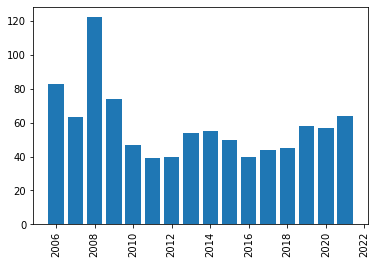

In [146]:
without_unknown = by_year.copy()
del without_unknown[-1]
plt.xticks(rotation=90)
_ = plt.bar(*zip(*sorted(without_unknown.items())))

## Local Editcount

In [147]:
def calc_bin(value):
    if value:
        return math.floor(math.log(value, 10))
    return None
by_edc = collections.Counter(map(lambda user: calc_bin(user.get("editcount")), unified_userinfo.values()))
print("Editcounter could not be retrieved:", by_edc[None])
del by_edc[None]
for step in sorted(by_edc.keys()):
    print("Between {:>5} and {:>7} edits: {}".format(10**step-1, 10**(step+1), by_edc[step]))
for index in range(6):
    if index not in by_edc:
        by_edc[index] = 0
        
by_edc

Editcounter could not be retrieved: 4
Between     0 and      10 edits: 39
Between     9 and     100 edits: 132
Between    99 and    1000 edits: 278
Between   999 and   10000 edits: 288
Between  9999 and  100000 edits: 178
Between 99999 and 1000000 edits: 20


Counter({4: 178, 3: 288, 5: 20, 2: 278, 1: 132, 0: 39})

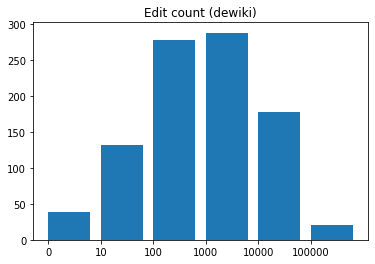

In [148]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1.set_title("Edit count (dewiki)")
_ = ax1.bar(*zip(*sorted(by_edc.items())), tick_label=[0, 10, 100,1000,10000,100000], align="edge")

## Global Editcount
Note: this is the **current** edit count, not from the time of the survey.

In [149]:
def calc_bin(value):
    if value:
        return math.floor(math.log(value, 10))
    return None
by_edc = collections.Counter(map(lambda user: calc_bin(user.get("global_editcount")), unified_userinfo.values()))
print("Editcounter could not be retrieved:", by_edc[None])
del by_edc[None]
for step in sorted(by_edc.keys()):
    print("Between {:>7} and {:>9} edits: {}".format(10**step-1, 10**(step+1), by_edc[step]))
for index in range(8):
    if index not in by_edc:
        by_edc[index] = 0

Editcounter could not be retrieved: 4
Between       0 and        10 edits: 36
Between       9 and       100 edits: 97
Between      99 and      1000 edits: 247
Between     999 and     10000 edits: 274
Between    9999 and    100000 edits: 217
Between   99999 and   1000000 edits: 56
Between  999999 and  10000000 edits: 7
Between 9999999 and 100000000 edits: 1


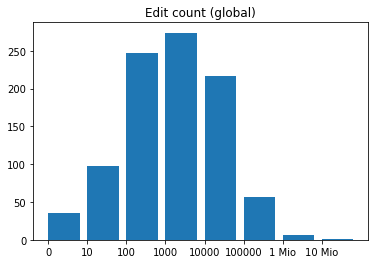

In [150]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1.set_title("Edit count (global)")
_ = plt.bar(*zip(*sorted(by_edc.items())), tick_label=[0, 10, 100,1000,10000,100000,'1 Mio','10 Mio'], align="edge")

## "Gender"-Setting
Note: this is **not** necessary the gender of the person

In [151]:
gender = collections.Counter(map(lambda user: user.get("gender", None), unified_userinfo.values()))
cprint(gender)

   None: 4
 female: 44
   male: 325
unknown: 566


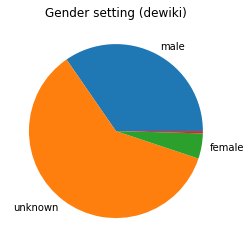

In [152]:
%matplotlib inline
fig1, ax1 = plt.subplots()
ax1.set_title("Gender setting (dewiki)")
_ = plt.pie(gender.values(), labels=gender.keys())
plt.savefig("byGender.svg")

## Home wiki
The "home" wiki of a user. Usually the wiki they registered their account originally. For better visualisation I also plot them with dewiki excluded.

In [153]:
home = collections.Counter(map(lambda user: user.get("home", None), unified_userinfo.values()))
cprint(home)

         None: 4
      alswiki: 1
      barwiki: 1
  commonswiki: 31
       cswiki: 1
       dewiki: 822
  dewikibooks: 4
   dewikinews: 1
 dewikisource: 3
 dewikivoyage: 1
 dewiktionary: 2
       enwiki: 43
       eowiki: 1
       eswiki: 1
       frwiki: 3
       huwiki: 2
       jawiki: 2
       lawiki: 1
       lbwiki: 1
mediawikiwiki: 4
       nlwiki: 1
       nowiki: 3
       swwiki: 1
  ukwikimedia: 1
 wikidatawiki: 4


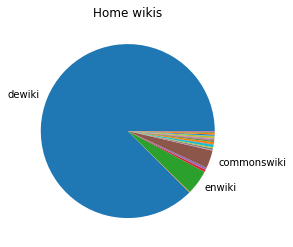

In [154]:
%matplotlib inline
fig1, ax1 = plt.subplots()
labels = [n if v > 5 else '' for n, v in home.items()]
ax1.pie(home.values(), labels=labels)
ax1.set_title("Home wikis")
plt.savefig("byhomewiki.svg")

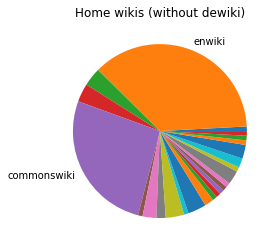

In [155]:
%matplotlib inline
fig1, ax1 = plt.subplots()
del home["dewiki"]
labels = [n if v > 5 else '' for n, v in home.items()]
ax1.pie(home.values(), labels=labels)
ax1.set_title("Home wikis (without dewiki)")
plt.savefig("byhomewiki_o.svg")

# Main wiki
Wiki on which the users made the most edits.

In [156]:
main_wiki = []
for user in unified_userinfo.values():
    if "merged" not in user:
        continue
    main_wiki.append(max(user["merged"], key=lambda w: w["editcount"])["wiki"])
main = collections.Counter(main_wiki)
cprint(main)

      alswiki: 1
  commonswiki: 77
       dewiki: 767
  dewikibooks: 1
 dewikisource: 5
 dewikivoyage: 1
 dewiktionary: 4
       enwiki: 20
       eowiki: 1
       etwiki: 1
      frrwiki: 1
       frwiki: 1
 frwikisource: 1
       huwiki: 1
       lawiki: 1
       lbwiki: 1
mediawikiwiki: 1
     metawiki: 1
       nlwiki: 1
       plwiki: 1
       ruwiki: 1
       swwiki: 1
 wikidatawiki: 45


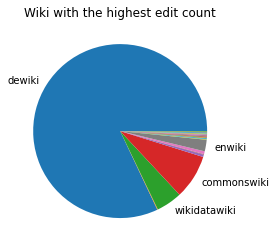

In [157]:
%matplotlib inline
fig1, ax1 = plt.subplots()
labels = [n if v > 5 else '' for n, v in main.items()]
_ = ax1.pie(main.values(), labels=labels)
ax1.set_title("Wiki with the highest edit count")
plt.savefig("bymainwiki.svg")

In [158]:
del main["dewiki"]
fig1, ax1 = plt.subplots()
labels = [n if v > 3 else '' for n, v in main.items()]
_ = plt.pie(main.values(), labels=labels)
ax1.set_title("Wiki with the highest edit count (without dewiki)")
plt.savefig("bymainwiki_o.svg")

# How did certain usergroups vote?
In the following I define a list of user groups and show how they voted and compare them to the total results.

Build a map of each voter's first choice.

In [159]:
first_choices = {row['username']: \
                 row['ballot'].split(',', 1)[0].strip() \
                     for row in named_ballots if row['username'] and row['ballot']}
len(first_choices)

943

In [160]:
def count_votes(usernames):
    '''Count the votes for a given group of users.'''
    votes = collections.defaultdict(lambda: 0)
    for user in usernames:
        votes[first_choices[user]] += 1
    return votes

Build a simple tally of all votes, as a baseline for comparison.

In [161]:
all_voters = first_choices.keys()
voters_per_area = count_votes(all_voters)

cprint(voters_per_area)

  BEO: 19
   BK: 30
 EDIT: 105
 EINZ: 180
 FORM: 33
INTER: 37
  KAT: 49
MEDIA: 28
 MERK: 38
  MOB: 58
 SUCH: 40
  UPL: 65
   VE: 46
 VERS: 44
 VORL: 88
   WD: 83


In [162]:
# Results in percentage as ordered dictionary
overall_results = collections.OrderedDict()
for key, num in sorted(voters_per_area.items(), key=lambda area: area[1], reverse=True):
    overall_results[key] = 100 * num / len(all_voters)

def print_comp_table(usernames):
    users_who_voted = [user for user in usernames if user in first_choices]
    missing_users_count = len(usernames) - len(users_who_voted)
    if missing_users_count:
        print("{} users didn't vote".format(missing_users_count))
    results = count_votes(users_who_voted)
    count = len(users_who_voted)
    '''print a table listing the result in percentage and the difference to the total results'''
    for key, overall_percentage in overall_results.items():
        percentage = 100 * results[key] / count
        print("{:<60}\t{:.2f}%\t\t{:+.2f}%".format(key, percentage, percentage - overall_percentage))

## New users
Users that created their account within the last year.

In [163]:
newusers = []
for username, userdata in unified_userinfo.items():
    registration = userdata["first_registration"]
    if isinstance(registration, Fake_Date):
        continue
    time_delta = datetime.now() - registration
    if time_delta.days < 365*1.5:
        newusers.append(username)

len(newusers)

83

How did this user group vote and what's the difference in percent points to the general election results:

In [164]:
print_comp_table(newusers)

EINZ                                                        	22.89%		+3.80%
EDIT                                                        	12.05%		+0.91%
VORL                                                        	6.02%		-3.31%
WD                                                          	3.61%		-5.19%
UPL                                                         	4.82%		-2.07%
MOB                                                         	9.64%		+3.49%
KAT                                                         	4.82%		-0.38%
VE                                                          	8.43%		+3.56%
VERS                                                        	4.82%		+0.15%
SUCH                                                        	3.61%		-0.63%
MERK                                                        	7.23%		+3.20%
INTER                                                       	3.61%		-0.31%
FORM                                                        	0.00%		-3.50%
BK                     

## Casual editors
Users that:
* registered at least a year ago and
* made at least 10 edits and
* make on average less then one edit per month

In [165]:
casual_users = []
for username, user_data in unified_userinfo.items():
    registration = user_data["first_registration"]
    if isinstance(registration, Fake_Date):
        continue
    edit_count = user_data.get("editcount", 0)
    time_delta = datetime.now() - registration
    edits_per_month = edit_count / (time_delta.days / 30)
    if time_delta.days > 365 and edit_count > 10 and edits_per_month < 1:
        casual_users.append(username)

In [166]:
len(casual_users)

109

In [167]:
print_comp_table(casual_users)

EINZ                                                        	7.34%		-11.75%
EDIT                                                        	17.43%		+6.30%
VORL                                                        	8.26%		-1.08%
WD                                                          	4.59%		-4.21%
UPL                                                         	9.17%		+2.28%
MOB                                                         	5.50%		-0.65%
KAT                                                         	0.92%		-4.28%
VE                                                          	10.09%		+5.21%
VERS                                                        	3.67%		-1.00%
SUCH                                                        	2.75%		-1.49%
MERK                                                        	6.42%		+2.39%
INTER                                                       	10.09%		+6.17%
FORM                                                        	4.59%		+1.09%
BK                   

## Powerusers
Users with more than 10'000 edits in german Wikipedia

In [168]:
powerusers = []
for user, user_data in unified_userinfo.items():
    if user_data.get("editcount", 0) > 10000:
        powerusers.append(user)

In [169]:
len(powerusers)

198

In [170]:
print_comp_table(powerusers)

EINZ                                                        	25.76%		+6.67%
EDIT                                                        	8.59%		-2.55%
VORL                                                        	6.57%		-2.77%
WD                                                          	10.61%		+1.80%
UPL                                                         	10.10%		+3.21%
MOB                                                         	4.55%		-1.61%
KAT                                                         	6.06%		+0.86%
VE                                                          	2.53%		-2.35%
VERS                                                        	4.55%		-0.12%
SUCH                                                        	3.03%		-1.21%
MERK                                                        	3.03%		-1.00%
INTER                                                       	1.52%		-2.41%
FORM                                                        	3.54%		+0.04%
BK                    

## Women

In [171]:
women = []
for user, user_data in unified_userinfo.items():
    if user_data.get("gender", "?") == "female":
        women.append(user)

len(women)

44

In [172]:
print_comp_table(women)

EINZ                                                        	20.45%		+1.37%
EDIT                                                        	9.09%		-2.04%
VORL                                                        	9.09%		-0.24%
WD                                                          	2.27%		-6.53%
UPL                                                         	6.82%		-0.07%
MOB                                                         	15.91%		+9.76%
KAT                                                         	4.55%		-0.65%
VE                                                          	4.55%		-0.33%
VERS                                                        	6.82%		+2.15%
SUCH                                                        	4.55%		+0.30%
MERK                                                        	0.00%		-4.03%
INTER                                                       	4.55%		+0.62%
FORM                                                        	2.27%		-1.23%
BK                     

## Admins

In [173]:
admin = []
for user, user_data in unified_userinfo.items():
    if "sysop" in user_data.get("groups", []):
        admin.append(user)

In [174]:
len(admin)

31

In [175]:
print_comp_table(admin)

EINZ                                                        	16.13%		-2.96%
EDIT                                                        	12.90%		+1.77%
VORL                                                        	3.23%		-6.11%
WD                                                          	9.68%		+0.88%
UPL                                                         	16.13%		+9.24%
MOB                                                         	6.45%		+0.30%
KAT                                                         	12.90%		+7.71%
VE                                                          	0.00%		-4.88%
VERS                                                        	0.00%		-4.67%
SUCH                                                        	0.00%		-4.24%
MERK                                                        	3.23%		-0.80%
INTER                                                       	0.00%		-3.92%
FORM                                                        	3.23%		-0.27%
BK                   

## File Uploader
People who uploaded at least 1000 files to Wikimedia Commons.

In [176]:
commonsusers = []
print("This takes some serious time...")
for user, user_data in unified_userinfo.items():
    for wiki in user_data.get("merged", []):
        if wiki["wiki"] == "commonswiki" and wiki["editcount"] > 1000:
            commonsuploads = get_commons_uploads(user, 1000)
            if commonsuploads >= 1000:
                commonsusers.append(user)

len(commonsusers)

This takes some serious time...


96

In [177]:
print_comp_table(commonsusers)

EINZ                                                        	15.62%		-3.46%
EDIT                                                        	4.17%		-6.97%
VORL                                                        	9.38%		+0.04%
WD                                                          	10.42%		+1.61%
UPL                                                         	27.08%		+20.19%
MOB                                                         	4.17%		-1.98%
KAT                                                         	5.21%		+0.01%
VE                                                          	3.12%		-1.75%
VERS                                                        	0.00%		-4.67%
SUCH                                                        	5.21%		+0.97%
MERK                                                        	2.08%		-1.95%
INTER                                                       	0.00%		-3.92%
FORM                                                        	1.04%		-2.46%
BK                   

## First choice EINZ, by editor tenure

2006: 13
2007: 10
2008: 16
2009: 20
2010: 12
2011: 6
2012: 4
2013: 9
2014: 10
2015: 3
2016: 6
2017: 13
2018: 13
2019: 20
2020: 10
2021: 15


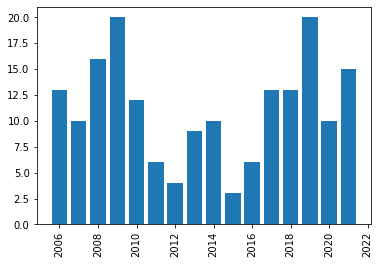

In [178]:
einz_voters = [user for username, user in unified_userinfo.items() if first_choices[username] == 'EINZ']
einz_by_year = collections.Counter(map(lambda user: user.get("first_registration").year, einz_voters))
cprint(einz_by_year)
without_unknown = einz_by_year.copy()
del without_unknown[-1]
plt.xticks(rotation=90)
_ = plt.bar(*zip(*sorted(without_unknown.items())))

# Ideas for further investigations
- How many people have a common.js?